# SARIMA (Seasonal Autoregressive Integrated Moving Average)

Source:
https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/

The Components of SARIMA

- **Autoregressive (AR) Component:** The "AR" in SARIMA signifies the autoregressive component, which models the relationship between the current data point and its past values. It captures the data's autocorrelation, meaning how correlated the data is with itself over time.

- **Integrated (I) Component:** The "I" in SARIMA indicates differencing, which transforms non-stationary data into stationary data. Stationarity is crucial for time series modelling. The integrated component measures how many differences are required to achieve stationarity.

- **Moving Average (MA) Component:** The "MA" in SARIMA represents the moving average component, which models the dependency between the current data point and past prediction errors. It helps capture short-term noise in the data.

- **Seasonal Differencing:**
Before we jump into SARIMA, it's essential to understand seasonal differencing. Seasonal differencing is the process of subtracting the time series data by a lag that equals the seasonality. This helps remove the seasonal component and makes the data stationary, allowing for more straightforward modeling. Seasonal differencing is often denoted as "D" in SARIMA.

The SARIMA Notation

SARIMA(p, d, q)(P, D, Q, s):

AR(p): Autoregressive component of order p
MA(q): Moving average component of order q
I(d): Integrated component of order d

Seasonal AR(P): Seasonal autoregressive component of order P
MA(Q): Seasonal moving average component of order Q
Seasonal I(D): Seasonal integrated component of order D

s: Seasonal period

## Dataset:

Source:
Dataset: Superstore (2015-2018)
https://www.kaggle.com/datasets/ankumagawa/dataset-superstore-20152018?resource=download

### Loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df=pd.read_csv('data/Dataset_Superstore_2015_2018.csv')
sales_data=df[['Order Date','Sales']]
sales_data=pd.DataFrame(sales_data)
sales_data['Order Date']=pd.to_datetime(sales_data['Order Date'])
print(sales_data.head())

  Order Date     Sales
0 2016-11-08  261.9600
1 2016-11-08  731.9400
2 2016-06-12   14.6200
3 2015-10-11  957.5775
4 2015-10-11   22.3680


In [3]:
df1 = sales_data.set_index('Order Date')

monthly_sales = df1.resample('M').mean()
monthly_sales.head()

/var/folders/tj/cfj9qmvs7150dnbbhjnzz1tw0000gq/T/ipykernel_62622/2206197000.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df1.resample('M').mean()


,Sales
Order Date,
2014-01-31,180.213861
2014-02-28,98.258522
2014-03-31,354.719803
2014-04-30,209.595148
2014-05-31,193.838418


### Extracting monthly sales

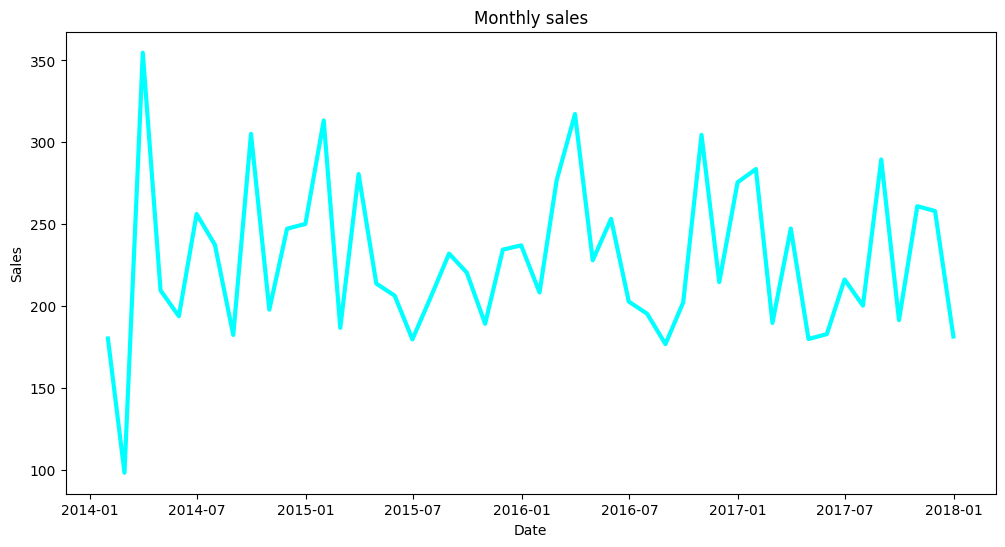

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Sales'], linewidth=3,c='cyan')
plt.title("Monthly sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


### Plotting the Monthly Sales

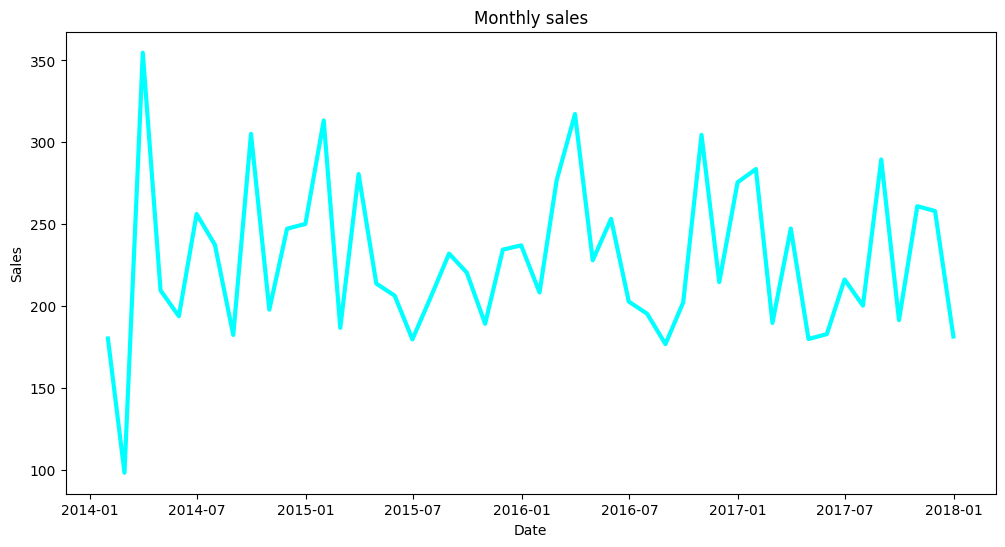

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Sales'], linewidth=3,c='cyan')
plt.title("Monthly sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


### Check Stationarity

In [6]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


check_stationarity(monthly_sales['Sales'])

ADF Statistic: -3.2865668298704303
p-value: 0.015489720191097284
Stationary


###  Identify Model Parameters

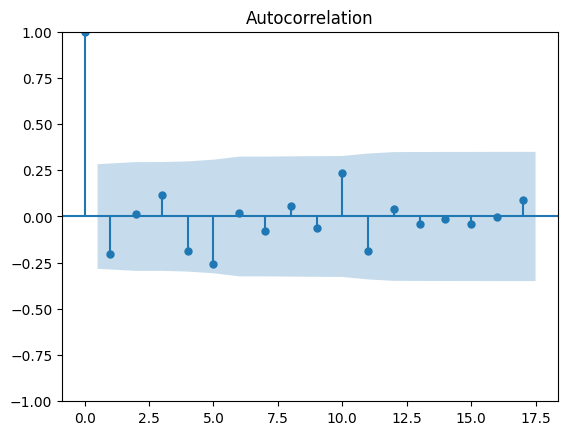

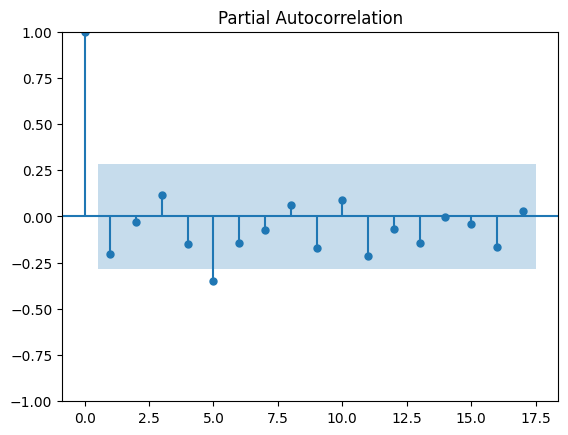

In [12]:
# Plot ACF and PACF
plot_acf(monthly_sales)
plot_pacf(monthly_sales)
plt.show()

### Fit the SARIMA Model

In [8]:
# Define SARIMA parameters
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12  # Assuming monthly seasonality

# Fit the SARIMA model
model = SARIMAX(monthly_sales, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
model

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.15152D+00    |proj g|=  2.74080D-01

At iterate    5    f=  4.06571D+00    |proj g|=  1.57031D-02

At iterate   10    f=  4.05982D+00    |proj g|=  4.46554D-03

At iterate   15    f=  4.03337D+00    |proj g|=  1.65492D-02

At iterate   20    f=  4.02336D+00    |proj g|=  3.56623D-02

At iterate   25    f=  4.01887D+00    |proj g|=  6.42866D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     36      1     0     0   

/Users/mjack6/GSU_Spring2025/MSA8200/venv_timeseries/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


### Generate Forecasts

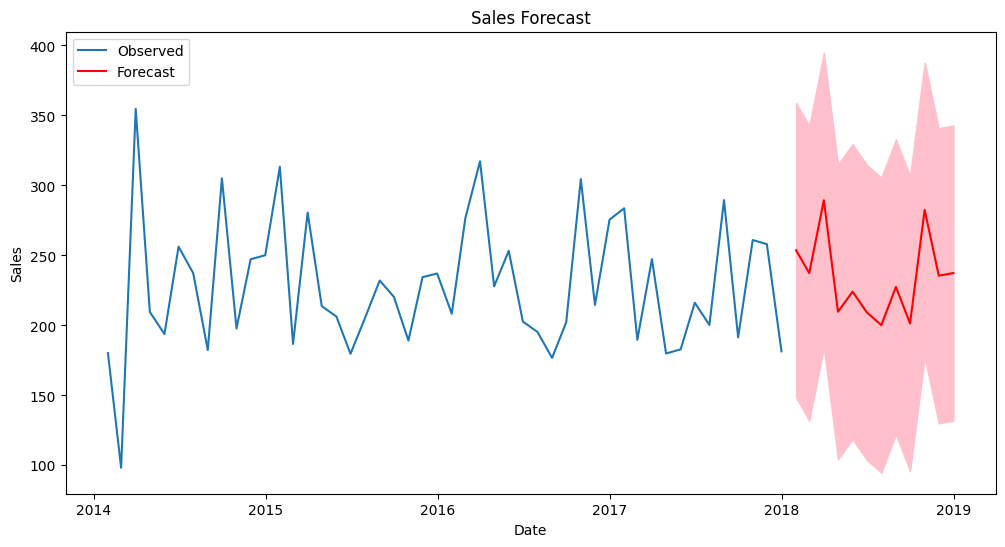

In [9]:
# Forecast future values
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

### Evaluate the Model

In [10]:
observed = monthly_sales[-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
print(f'MAE: {mae}')
print(f'MSE: {mse}')


MAE: 30.815754586318388
MSE: 1302.5204299270165
